In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scienceplots
import sys
import torch
import torchvision
import cv2

from contextlib import nullcontext
from functools import partialmethod
from pprint import pp
from pytorch_grad_cam import AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import ConfusionMatrixDisplay
from torch import nn, optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

plt.rcParams["font.family"] = "serif"

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using {device} device!")

Using cuda device!


# 01. Загрузка данных

## Объявление констант

In [3]:
TORCH_SEED = 512
DATASET_DIR = "../data/cifake-real-and-ai-generated-synthetic-images"
OUTPUT_DIR = "" # Дополнить, когда понадобиться
DATA_SPLITS = ["train", "test"]
LABELS = ["REAL", "FAKE"]
INPUT_SIZE = (32, 32)
BATCH_SIZE = 256
EPOCHS = 100
PATIENCE = 10
VERBOSE = False
VIS_NCOLS = 32
VIS_IMG_SIZE = 1

In [4]:
# Устанавливаем random_seed
torch.manual_seed(TORCH_SEED)

## Переопределение таргета.
**До переопределения: {FAKE: 0, REAL: 1}.**

**После определения: {FAKE: 1, REAL: 0}.**

In [5]:
class TargetMapper:
    def __init__(self, labels):
        self.labels_dict = {v: k for k, v in enumerate(labels)}
        self.labels_list = sorted(labels)

    def __call__(self, target):
        return self.labels_dict[self.labels_list[target]]

## Загрузка данных через ImageFolder
**Внимание! Во избежание проблем с дальнейшей работой датасета не нужно пользоваться данными, которые лежат внутри атрибутов .samples, .classes, .class_to_idx, если в ImageFolder был реализован transform. В этих атрибутах данные отображаются без трансформации**

[Принципиальное отличие между ImageFolder и DataLoader.](https://medium.com/jun94-devpblog/pytorch-1-transform-imagefolder-dataloader-7f75f0a460c0)

In [6]:
# Предварительная загрузка и трансформация данных из локальной папки на ПК
data = {
    # Создаем словарь, где по ключу train/test будут лежать соответствующие данные
    # По очереди обращаемся к папкам train/test, чтобы загрузить оттуда данные
    split: ImageFolder(
        # Если путь f"{DATASET_DIR}/{split}" содержит другие папки, то названия этих папок устанавливаются в качестве
        # классов (LABELS) для данных в папке f"{DATASET_DIR}/{split}".
        # Узнать метки классов можно с помощью вызова data['train'].classes
        f"{DATASET_DIR}/{split}",
        #
        transform=transforms.Compose(
            [
                transforms.Resize(INPUT_SIZE),
                transforms.ToTensor(),
            ]
        ),
        target_transform=TargetMapper(LABELS),
    )
    for split in DATA_SPLITS
}

print("Данные загружены!")

Данные загружены!


In [7]:
# Основные атрибуты класса ImageFolder
print(data['train'].classes) # Множество классов в датасете

print(data['train'].extensions) # Множество расширений файлов в датасете

#ВНИМАНИЕ! Данный атрибут не отображает изменения после target_transform. Т.е. класс изображения будет указываться до target_transform
print(data['train'].class_to_idx) # Отобразить мэппинг класса и индекса.

#ВНИМАНИЕ! Данный атрибут не отображает изменения после target_transform. Т.е. класс изображения будет указываться до target_transform
# data['train'].samples # Отобразить список всех объектов в train (выводится список кортежей (объект\путь до изображения, класс изображения))

['FAKE', 'REAL']
('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
{'FAKE': 0, 'REAL': 1}


## Предварительный просмотр
Видим, что исходный тензор имеет размерность (3, 32, 32), следовательно перед визуализацией, нужно поменять местами размерности тензора.

In [8]:
image, label = data["test"][0]

print("Sample image:")
print(f"  shape: {image.shape}")
print(f"  label: {label} ({LABELS[label]})")

Sample image:
  shape: torch.Size([3, 32, 32])
  label: 1 (FAKE)


## Штучная визуализация

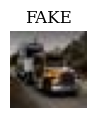

In [9]:
# Выведем FAKE изображение
image, label = data["train"][0]

plt.figure(figsize=(VIS_IMG_SIZE, VIS_IMG_SIZE))
plt.axis("off") # Убираем оси 
plt.title(LABELS[label]) # Метка класса
plt.imshow(torch.permute(image, (1, 2, 0)))
plt.show()

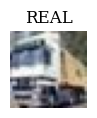

In [10]:
# Выведем REAL изображение
image, label = data["train"][50000]

plt.figure(figsize=(VIS_IMG_SIZE, VIS_IMG_SIZE))
plt.axis("off") # Убираем оси 
plt.title(LABELS[label]) # Метка класса
plt.imshow(torch.permute(image, (1, 2, 0)))
plt.show()

## Используем DataLoader для iterable обертки наших данных

ImageFolder class: Responsible for loading images from train and val folders into a PyTorch dataset. DataLoader class: Enables us to wrap an iterable around our dataset so that data samples can be efficiently accessed by our deep learning model.

In [11]:
data_loaders = {
    split: DataLoader(
        data[split],
        batch_size=BATCH_SIZE,
        shuffle=True if split == "train" else False, # Для train нужен shuffle. Для test не нужен.
        num_workers=0, # ВНИМАНИЕ!!! ЭТОТ ПАРАМЕТР ДОЛЖЕН БЫТЬ 0. ЕСЛИ ОН НЕ НОЛЬ, ТО ФУНКЦИЯ ЗАВИСАЕТ И НЕ ВЫПОЛНЯЕТСЯ. С чем это связано я пока не понял. https://discuss.pytorch.org/t/looping-over-dataloader-takes-to-long/189201 
        pin_memory=True,
    )
    for split in DATA_SPLITS
}

print("DataLoader инициализирован")

DataLoader инициализирован


## Батчевая визуализация
Отобразим изображения из двух батчей train и test выборки

In [12]:
def show_batches(
    split,
    image_mapper=lambda image: image.permute(1, 2, 0),
    show_label=True,
    batch_indices=lambda data_loader: [0, len(data_loader) - 2],
):
    nrows = -(BATCH_SIZE // -VIS_NCOLS)
    batch_index = -1

    for images, labels in data_loaders[split]:
        batch_index += 1

        if batch_index not in batch_indices(data_loaders[split]):
            continue

        plt.figure(figsize=(VIS_NCOLS * VIS_IMG_SIZE, nrows * VIS_IMG_SIZE), dpi=300)

        if show_label:
            plt.subplots_adjust(hspace=0.6)

        for i, (image, label) in enumerate(zip(images, labels)):
            plt.subplot(nrows, VIS_NCOLS, i + 1)
            plt.axis("off")

            if show_label:
                plt.title(LABELS[label])

            plt.imshow(image_mapper(image))

        plt.show()

        print(f"Visualized batch #{batch_index + 1} of the {split} split!")

Let's preview the images.

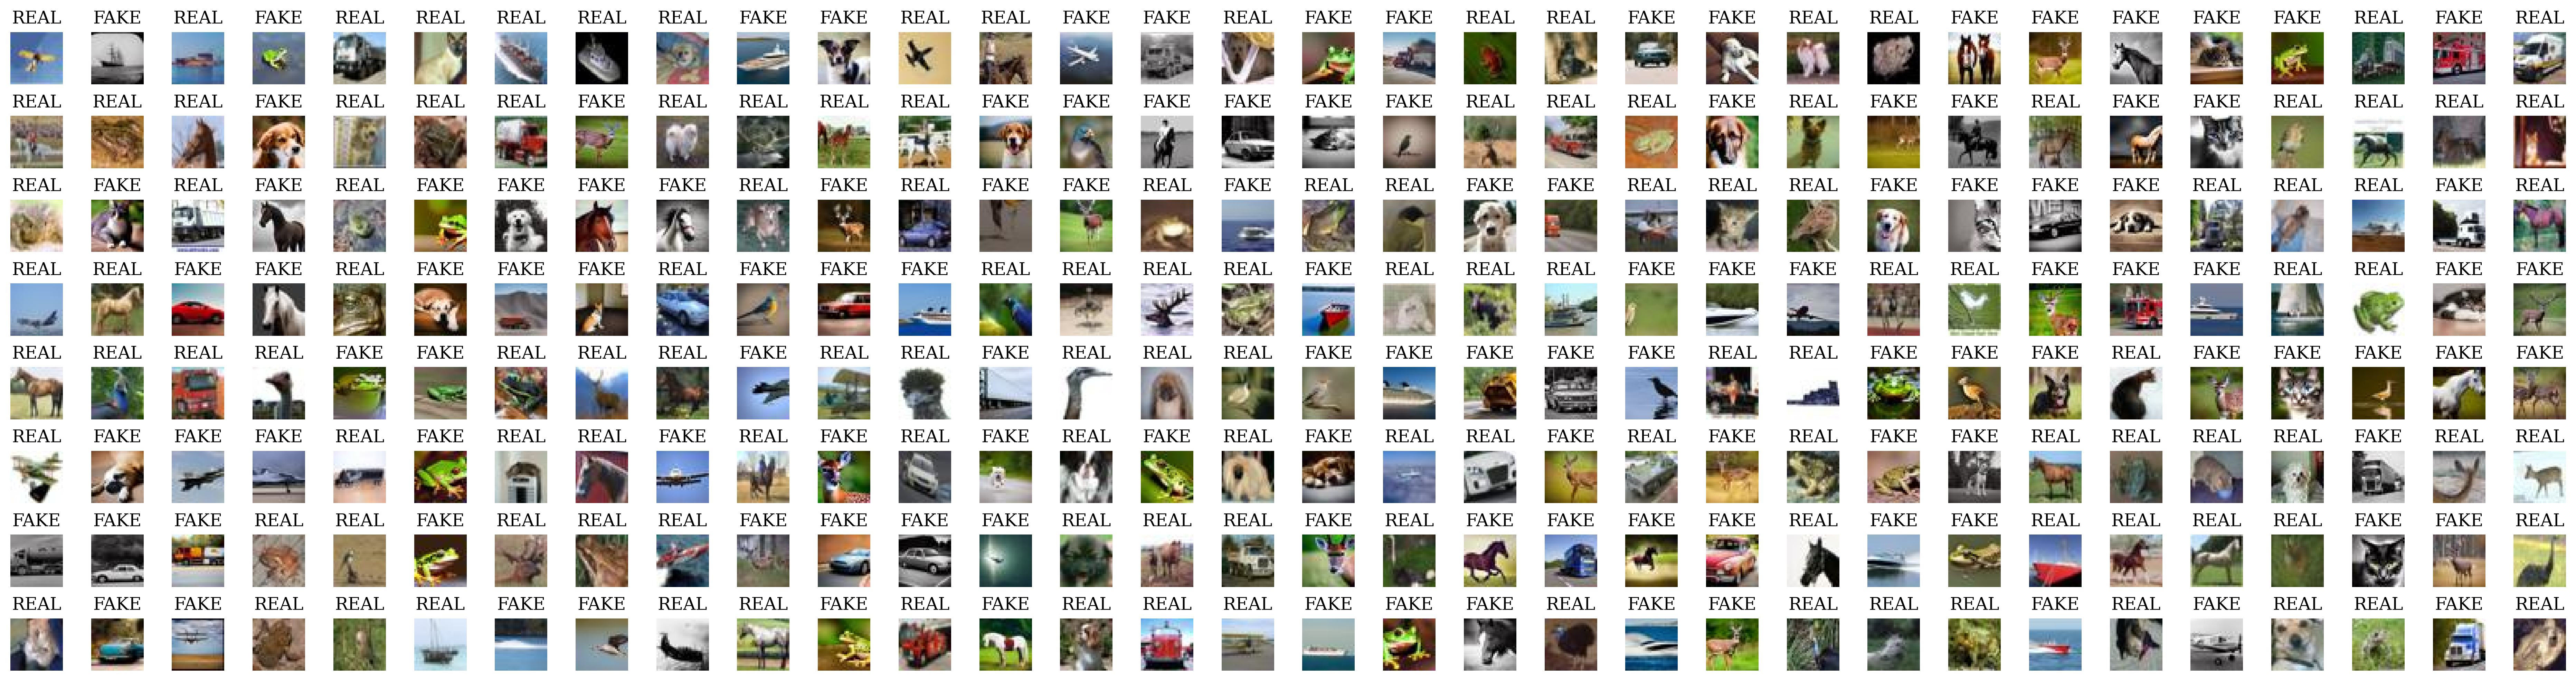

Visualized batch #1 of the train split!


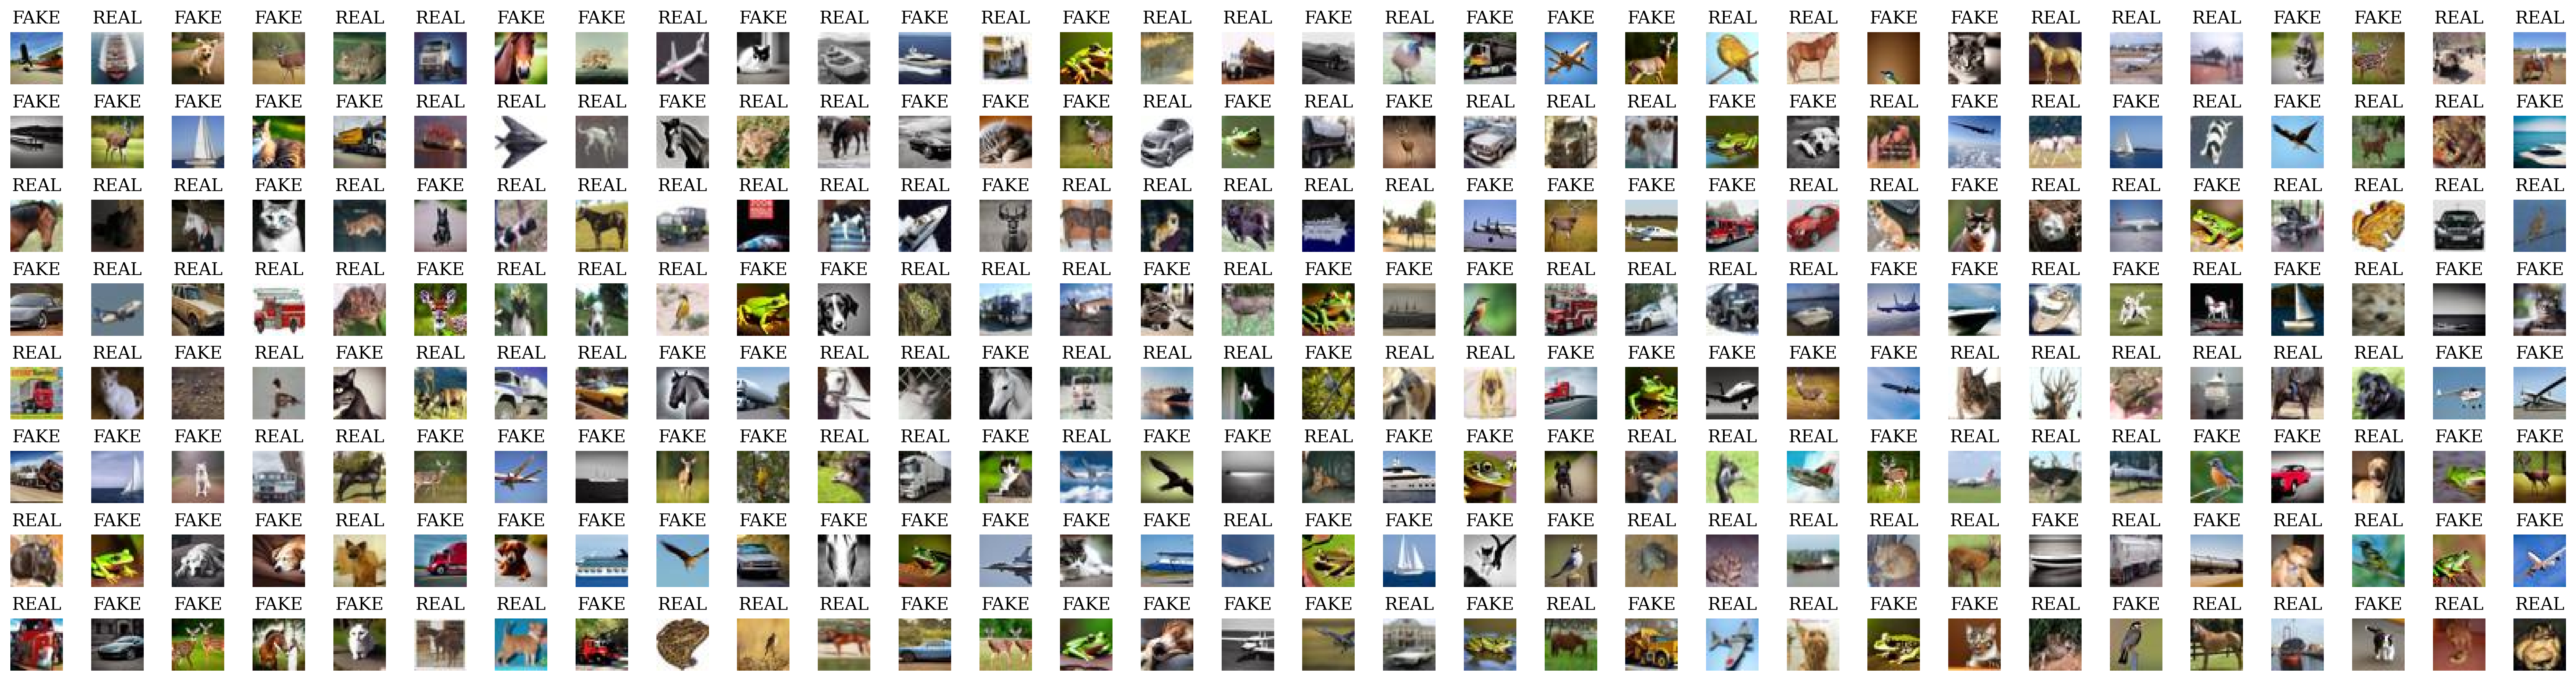

Visualized batch #390 of the train split!


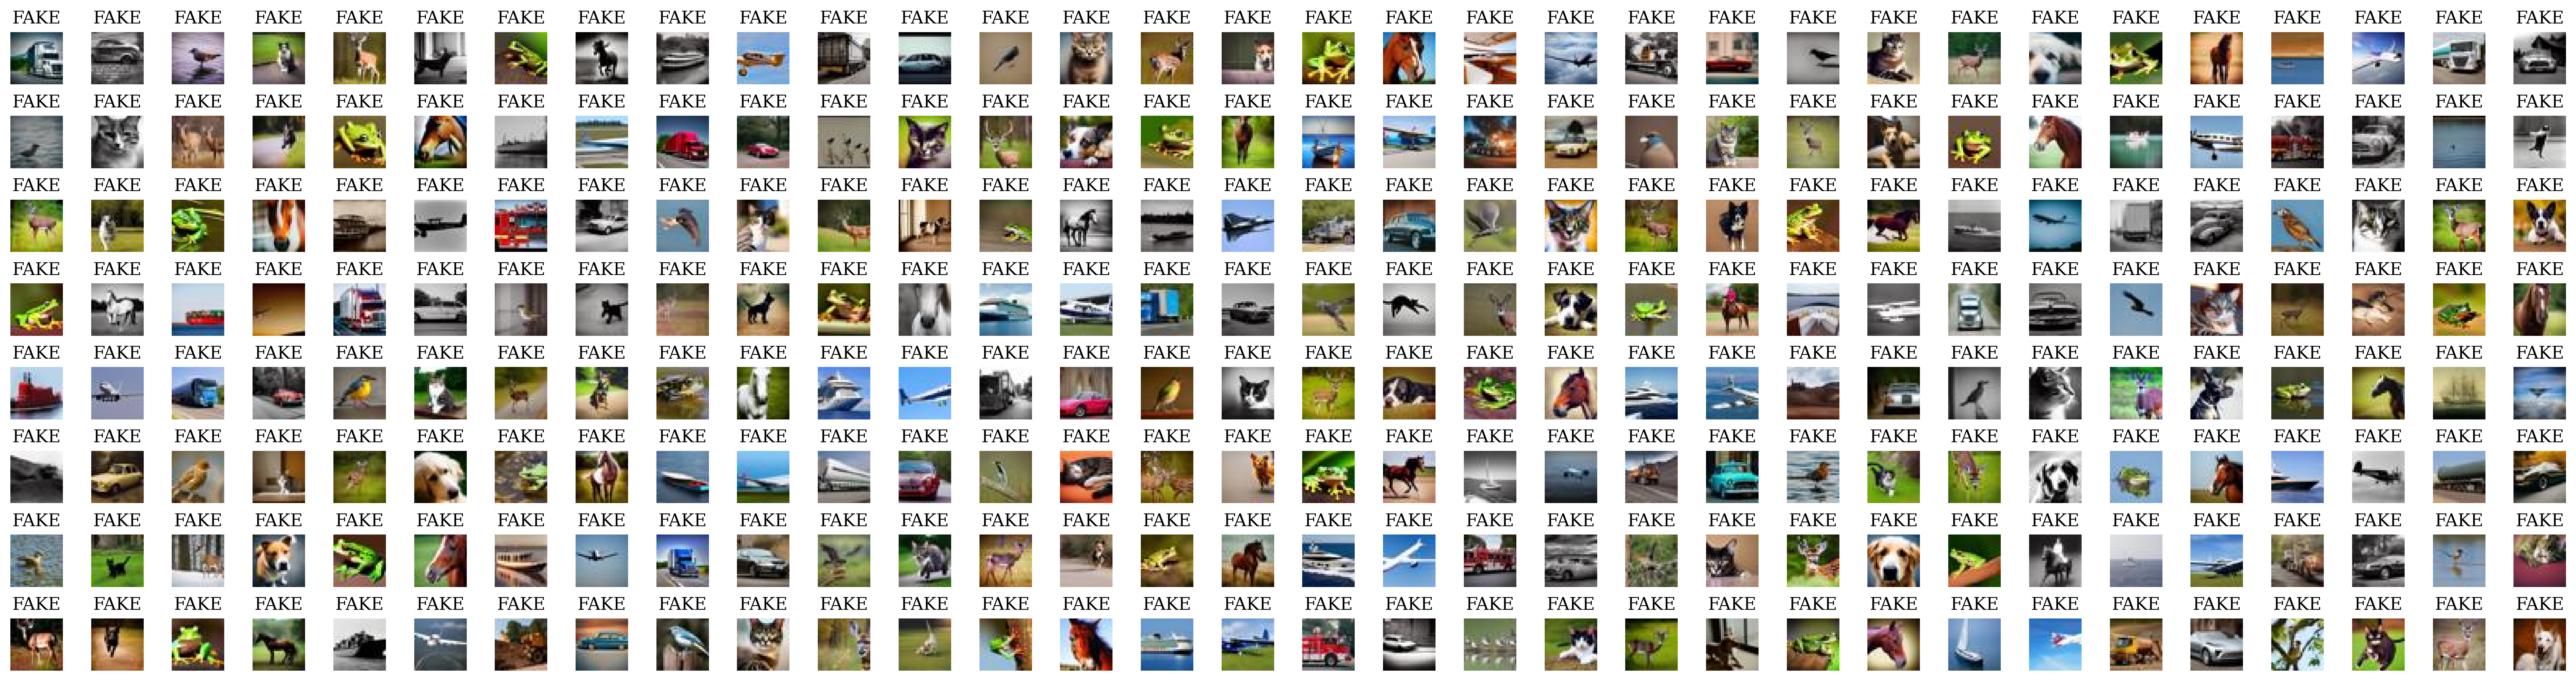

Visualized batch #1 of the test split!


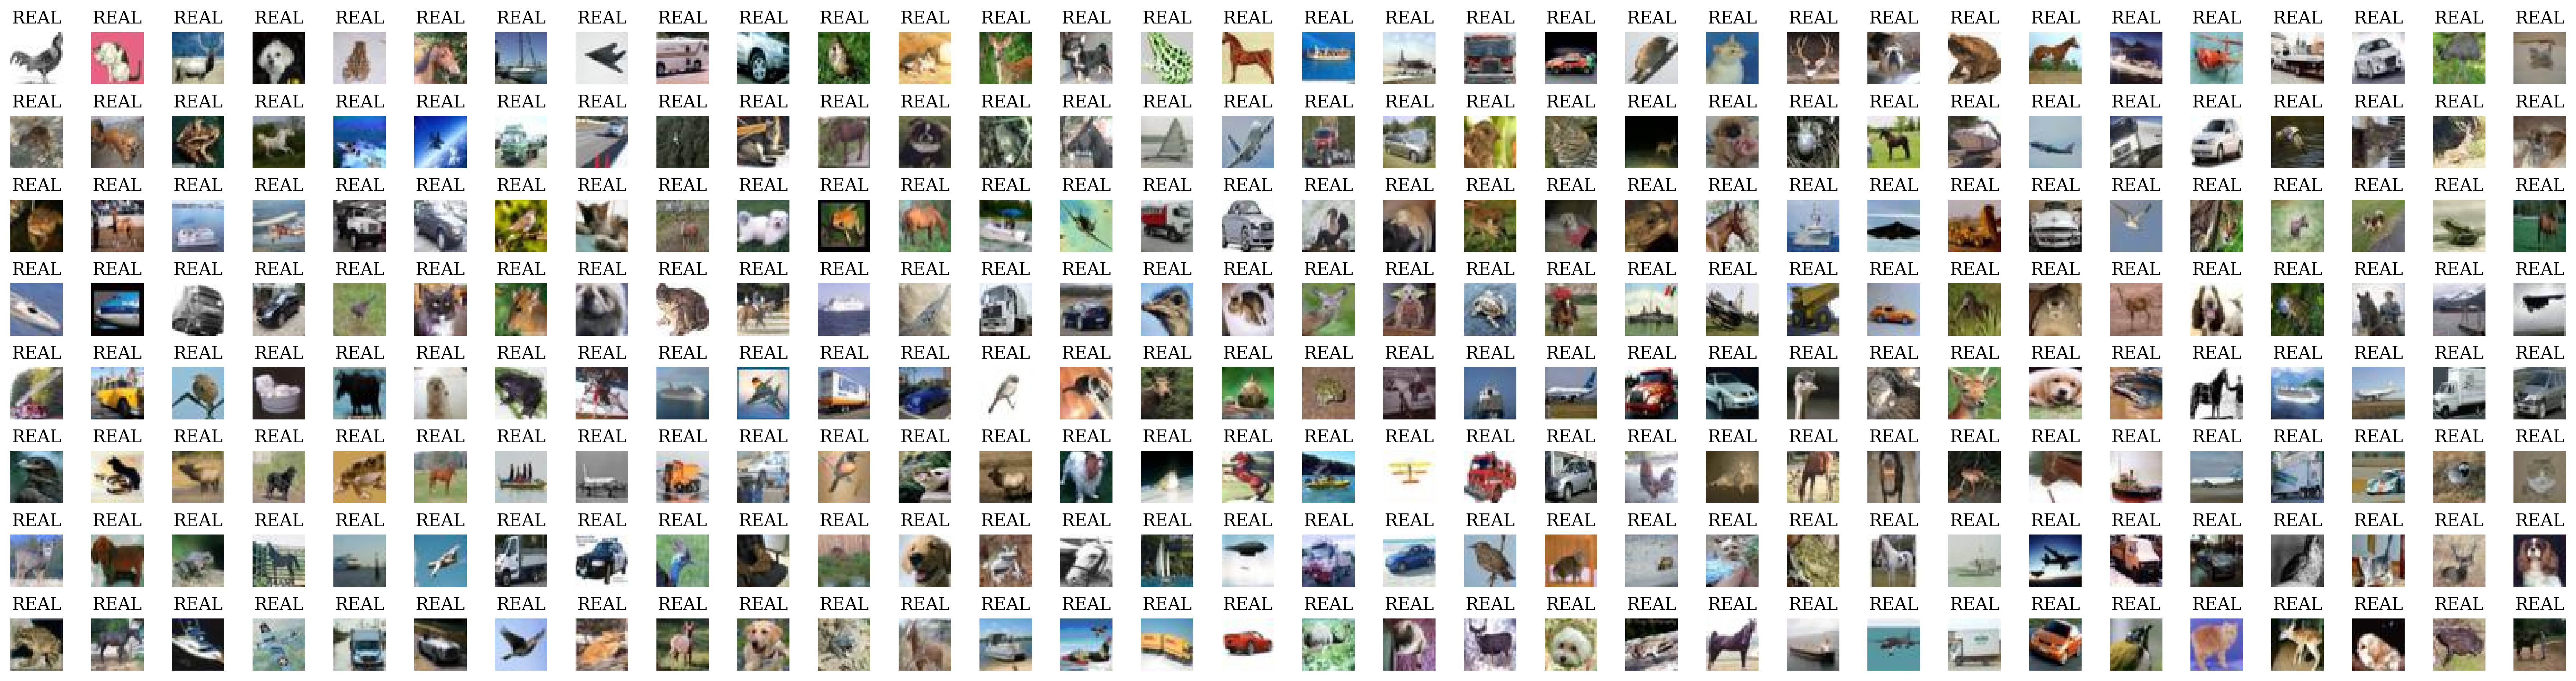

Visualized batch #78 of the test split!


In [13]:
for split in DATA_SPLITS:
    show_batches(split)

# 02. EDA

**Произведем загрузку изображений, но уберем трансформацию размеров изображений, чтобы была возможность проанализировать сырые данные**

In [14]:
# Предварительная загрузка и трансформация данных из локальной папки на ПК
data = {
    # Создаем словарь, где по ключу train/test будут лежать соответствующие данные
    # По очереди обращаемся к папкам train/test, чтобы загрузить оттуда данные
    split: ImageFolder(
        # Если путь f"{DATASET_DIR}/{split}" содержит другие папки, то названия этих папок устанавливаются в качестве
        # классов (LABELS) для данных в папке f"{DATASET_DIR}/{split}".
        # Узнать метки классов можно с помощью вызова data['train'].classes
        f"{DATASET_DIR}/{split}",
        #
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        ),
        target_transform=TargetMapper(LABELS),
    )
    for split in DATA_SPLITS
}

print("Данные загружены!")

Данные загружены!


## Расчет средних, минимальных и максимальных размеров картинки.

In [15]:
widths = []
heights = []
for i_split in DATA_SPLITS: # произведем замеры всех изображения (на train и test)
    for i_img in tqdm(data[i_split]):
        image = i_img[0]
        image = torch.permute(image, (1, 2, 0))
        widths.append(image.shape[0]) # заносим в список параметры широты всех изображений
        heights.append(image.shape[1]) # заносим в список параметры широты всех изображений  

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:04<00:00, 4384.56it/s]


In [16]:
# Делаем расчет средних, минимальных и максимальных размеров изображений
array_sizes = np.multiply(widths, heights) # Создаем массив всех размеров (width*heights)

avg_size = np.mean(array_sizes)
min_size = np.min(array_sizes)
max_size = np.max(array_sizes)

In [17]:
print(f'Средний размер изображения: {avg_size}')
print(f'Минимальный размер изображения: {min_size}')
print(f'Максимальный размер изображения: {max_size}')
print("Видим, что размеры изображений в датасете одинаковые")

Средний размер изображения: 1024.0
Минимальный размер изображения: 1024
Максимальный размер изображения: 1024
Видим, что размеры изображений в датасете одинаковые


## Расчет среденего и стандартного отклонения по RGB каналам.
Расчет std/mean будем производить только на train выборке, поскольку в дальнейшем, если мы соберемся нормализовать датасет, то делать это будем именно на основании данных с train, чтобы не допустить утечки информации.

In [18]:
# тензоры для хранения прокси-информации по RGB каналам
tsum = torch.tensor([0.0, 0.0, 0.0])
tsum_sq = torch.tensor([0.0, 0.0, 0.0])
cntTrain = len(data['train']) * widths[0] * heights[0] # количество пикселей в выборке

for i_img in tqdm(data['train']):
    tsum += i_img[0].sum(axis=(1, 2))
    tsum_sq += (i_img[0]**2).sum(axis=(1, 2))
    
mean_rgb = tsum / cntTrain
var_rgb = (tsum_sq / cntTrain) - (mean_rgb**2) # E(X^2) - E^2(X)
std_rgb = torch.sqrt(var_rgb)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:25<00:00, 3990.33it/s]


In [19]:
print(f"Средние значения по RGB-каналам: {mean_rgb}")
print(f"Диспресии по RGB-каналам: {var_rgb}")
print(f"Стандартные отклонения по RGB-каналам: {std_rgb}")

Средние значения по RGB-каналам: tensor([0.4720, 0.4629, 0.4178])
Диспресии по RGB-каналам: tensor([0.0564, 0.0564, 0.0707])
Стандартные отклонения по RGB-каналам: tensor([0.2376, 0.2374, 0.2659])


## Распределение по классам

In [20]:
dct_targetHist = {}

for i_split in DATA_SPLITS:
    cnt_fake = 0
    cnt_real = 0
    for _, target in tqdm(data[i_split]):
        if target == 1:
            cnt_fake += 1
        elif target == 0: 
            cnt_real += 1
    dct_targetHist[i_split] = dct_targetHist.get(i_split, {'fake': cnt_fake, 
                                                           'real': cnt_real})

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:04<00:00, 4475.65it/s]


In [21]:
dct_targetHist

{'train': {'fake': 50000, 'real': 50000},
 'test': {'fake': 10000, 'real': 10000}}

### Визуализация

In [22]:
df_display = pd.DataFrame(dct_targetHist).reset_index(names='target_name')

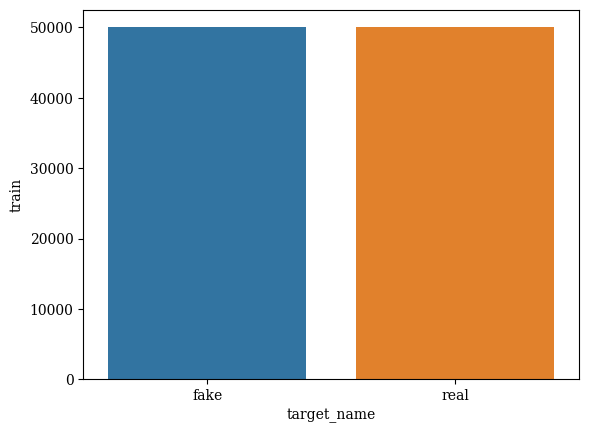

In [23]:
sns.barplot(df_display, x="target_name", y="train")
plt.show()

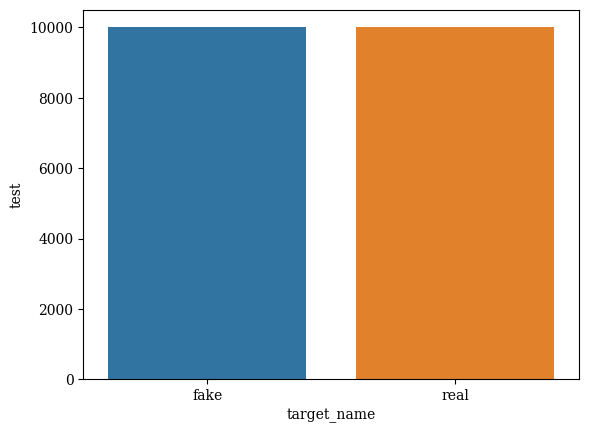

In [24]:
sns.barplot(df_display, x="target_name", y="test")
plt.show()